In [2]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_z_ft_approx
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from isca_tools.papers.byrne_2021 import get_quant_ind

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
def get_P(ds):
    return ds.PS * ds.hybm

## Load data and average over `sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [5]:
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import ds, get_P

ds = ds['aquaplanet']
p_ft = ds.p_ft
temp_surf_lcl_calc = ds.temp_surf_lcl_calc

In [6]:
# Take average over all days for which error satisfies convective threshold
error_thresh = 0.25
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(
    ds.modParc1_error.sum(dim='layer') / ds.modParc1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)

ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
ds_quant = ds.where(mask_fit).mean(dim='sample')

In [7]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

In [8]:
# Compute all variables from the average quantities, as makes cannot compare individual samples when considering change with warming
# And same as previous method
ds_quant['rh_REFHT'] = ds_quant['QREFHT'] / sphum_sat(ds_quant['TREFHT'], ds_quant['PREFHT'])
ds_quant['mse_REFHT'] = moist_static_energy(ds_quant.TREFHT, ds_quant.QREFHT, ds_quant.ZREFHT)
ds_quant['mse_ft_sat_env'] = moist_static_energy(ds_quant.T_ft_env, sphum_sat(ds_quant.T_ft_env, p_ft),
                                                 ds_quant.Z_ft_env)
ds_quant['epsilon'] = ds_quant['mse_REFHT'] - ds_quant['mse_ft_sat_env']
z_diff = ds_quant.Z_ft_env - ds_quant.ZREFHT
z_diff_theory = get_z_ft_approx(ds_quant.TREFHT, ds_quant.T_ft_env, ds_quant.PREFHT, p_ft)
ds_quant['z_error'] = g * (z_diff - z_diff_theory) / 1000  # units of kJ/kg

## $\epsilon$ Approximation
Above we showed that

* $h^{\dagger}_{parc} = h^{\dagger}_{FTenv} + \beta_{FT1}(\sigma_{FT}^{-R\eta_M /g}r_s^{R\eta_M \nu /g} - 1)T_{FT} + A_{\eta_M}$
* $h^{\dagger}_{parc} = h^{\dagger}_{senv} + \beta_{s1} \frac{R\nu}{g}\eta_D \ln (r_s) T_s + A_{\eta_D}$

where $A_{\eta_M}$ is a taylor series error associated with assuming $\eta_M$ is small, and $A_{\eta_D}$ is a taylor series approximation associated with assuming $\eta_D$ is small.

Then $\epsilon + A_z = h_s - h^*_{FT} = h^{\dagger}_{senv} - h^{\dagger}_{FTenv}$. And upon equating the above equations for $h^{\dagger}_{parc}$, we get:

$\epsilon + A_z = A_{\eta_M} - A_{\eta_D} + \beta_{FT1}\frac{R}{g}\eta_M\ln(\frac{r_s^{\nu}}{\sigma_{FT}})T_{FT} - \beta_{s1} \frac{R\nu}{g}\eta_D \ln (r_s) T_s$

Note that the difference between the Theory and Theory+Error line below includes the effect of $A_z$, but in the scaling factor derivation this will cancel out, so no need to worry about it.

Below we decompose the variation of $\epsilon$ with $x$ into these different variables (all no $\eta$ variables are non-linear with $\eta$ also varying because $\tilde{\eta}=0$ so all linear variation in other variables is 0).

In [9]:
def get_epsilon_theory(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D, lapse_diff_M, p_ft=p_ft,
                       temp_lcl_ref=temp_surf_lcl_calc):
    R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(temp_ft, p_surf, p_ft)
    beta_s1 = get_theory_prefactor_terms(temp_surf, p_surf, p_ft, sphum=rh_surf * sphum_sat(temp_surf, p_surf))[3]
    exponent_use = R * lapse_diff_M / g
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    cont_ft = beta_ft1 * temp_ft * exponent_use * np.log(sigma_lcl / sigma_ft)
    exponent_use = R * lapse_diff_D / g
    cont_surf = beta_s1 * temp_surf * exponent_use * np.log(sigma_lcl)
    return (cont_ft - cont_surf) / 1000, cont_ft / 1000, cont_surf / 1000


def get_epsilon_error(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D, lapse_diff_M, p_ft=p_ft,
                      temp_lcl_ref=temp_surf_lcl_calc):
    R_mod = get_theory_prefactor_terms(temp_ft, p_surf, p_ft)[0]
    # Returns the error terms A_{\eta_D} and A{\eta_M}
    # Ignores the z error term - deal with separately
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    exponent_use = R * lapse_diff_M / g
    temp_ft_parcel = temp_ft * sigma_lcl ** exponent_use * sigma_ft ** (-exponent_use)
    exponent_use = R * lapse_diff_D / g
    temp_surf_parcel = temp_surf * sigma_lcl ** exponent_use

    mse_mod_ft_parcel = ((c_p + R_mod) * temp_ft_parcel + L_v * sphum_sat(temp_ft_parcel, p_ft))
    mse_mod_ft_env = ((c_p + R_mod) * temp_ft + L_v * sphum_sat(temp_ft, p_ft))

    mse_mod_surf_parcel = ((c_p - R_mod) * temp_surf_parcel + L_v * rh_surf * sphum_sat(temp_surf_parcel, p_surf))
    mse_mod_surf_env = ((c_p - R_mod) * temp_surf + L_v * rh_surf * sphum_sat(temp_surf, p_surf))

    # epsilon_exact = ((mse_mod_ft_parcel - mse_mod_ft_env) - (mse_mod_surf_parcel - mse_mod_surf_env)) / 1000
    cont_ft_approx, cont_surf_approx = get_epsilon_theory(temp_surf, temp_ft, rh_surf, p_surf, lapse_diff_D,
                                                          lapse_diff_M, p_ft, temp_lcl_ref)[1:]
    error_ft = (mse_mod_ft_parcel - mse_mod_ft_env) / 1000 - cont_ft_approx
    error_surf = (mse_mod_surf_parcel - mse_mod_surf_env) / 1000 - cont_surf_approx
    return error_ft, error_surf

In [10]:
ds_ref['lapse_D'] = ds_ref.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_ref['lapse_M'] = ds_ref.modParc1_lapse.isel(layer=1) / 1000

ds_quant['lapse_D'] = ds_quant.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_quant['lapse_M'] = ds_quant.modParc1_lapse.isel(layer=1) / 1000

In [11]:
ds_quant['epsilon_theory'] = \
    get_epsilon_theory(ds_quant.TREFHT, ds_quant.T_ft_env, ds_quant.rh_REFHT, ds_quant.PREFHT, ds_quant.lapse_D,
                       ds_quant.lapse_M)[0]
ds_quant['lapse_M_error'], ds_quant['lapse_D_error'] = get_epsilon_error(ds_quant.TREFHT, ds_quant.T_ft_env,
                                                                         ds_quant.rh_REFHT,
                                                                         ds_quant.PREFHT, ds_quant.lapse_D,
                                                                         ds_quant.lapse_M)
ds_quant['epsilon_av_error'] = ds_quant['epsilon'] - (ds_quant['epsilon_theory'] + ds_quant['lapse_M_error'] -
                                                      ds_quant['lapse_D_error'] - ds_quant['z_error'])

In [12]:
ds_eps = ds_quant[['TREFHT']]
ds_eps['lapse_D'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       ds_quant['lapse_D'], 0)[0]
ds_eps['lapse_M'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       0, ds_quant['lapse_M'])[0]
ds_eps = ds_eps.drop_vars('TREFHT')

ds_eps['TREFHT'] = get_epsilon_theory(ds_quant.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                      ds_quant['lapse_D'], ds_quant['lapse_M'])[0]
ds_eps['TREFHT'] = ds_eps['TREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']

ds_eps['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_quant.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                        ds_quant['lapse_D'], ds_quant['lapse_M'])[0]
ds_eps['T_ft_env'] = ds_eps['T_ft_env'] - ds_eps['lapse_D'] - ds_eps['lapse_M']

ds_eps['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_quant.rh_REFHT, ds_ref.PREFHT,
                                        ds_quant['lapse_D'], ds_quant['lapse_M'])[0]
ds_eps['rh_REFHT'] = ds_eps['rh_REFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']

ds_eps['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_quant.PREFHT,
                                      ds_quant['lapse_D'], ds_quant['lapse_M'])[0]
ds_eps['PREFHT'] = ds_eps['PREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
ds_quant['epsilon_theory_linear'] = ds_eps['lapse_D'] + ds_eps['lapse_M']
ds_quant['epsilon_nl_error'] = ds_quant['epsilon_theory'] - ds_quant['epsilon_theory_linear']

ds_eps = ds_eps.transpose('tau_lw', 'quant', 'lat')
ds_quant = ds_quant.transpose('tau_lw', 'quant', 'lat', 'lev', 'layer')

In [13]:
lat_weights = np.cos(np.deg2rad(ds.lat))
percentile_label = 'Temperature Percentile, $x$'
colors_cont = {'T_ft_env': 'C2',
               'TREFHT': 'C3',
               'rh_REFHT': 'C0',
               'lapse_M': 'C1', 'lapse_M_error': 'C1',
               'lapse_D': 'C4', 'lapse_D_error': 'C4',
               'PREFHT': 'C6',
               'epsilon_av_error': 'C6',
               'epsilon_nl_error': 'C5'}

label_cont = {'T_ft_env': '$T_{FT}$', 'TREFHT': '$T_s$', 'rh_REFHT': '$r_s$', 'PREFHT': '$p_s$',
              'lapse_M': '$\eta_M$', 'lapse_M_error': '$A_{\eta_M}$',
              'lapse_D': '$\eta_D$', 'lapse_D_error': '$A_{\eta_D}$',
              'epsilon_av_error': '$A_{\epsilon \\text{av}}$',
              'epsilon_nl_error': '$A_{\epsilon \\text{NL}}$', }

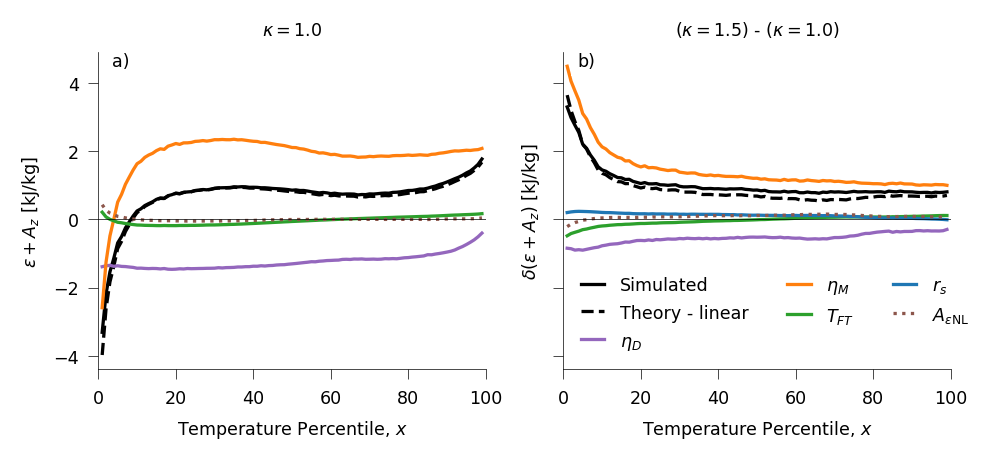

In [14]:
plot_val_thresh = 0.2

fig, ax = plt.subplots(1, ds_quant.tau_lw.size, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for k in range(2):
    if k == 0:
        ax[k].set_title(f"$\kappa = {ds_quant.tau_lw[k]:.1f}$")
        func_use = lambda x: np.average(x.isel(tau_lw=0), axis=1, weights=lat_weights)
    else:
        ax[k].set_title(f"($\kappa = {ds_quant.tau_lw[1]:.1f}$) - ($\kappa = {ds_quant.tau_lw[0]:.1f}$)")
        func_use = lambda x: np.average(x.isel(tau_lw=1) - x.isel(tau_lw=0), axis=1, weights=lat_weights)
    ax[k].plot(ds_quant.quant, func_use(ds_quant['epsilon'] + ds_quant['z_error']), color='k', label='Simulated')
    ax[k].plot(ds_quant.quant, func_use(ds_quant['epsilon_theory_linear']), color='k', label='Theory - linear',
               linestyle='--')
    for key in ds_eps:
        var = func_use(ds_eps[key])
        if np.abs(var).max() > plot_val_thresh:
            ax[k].plot(ds_quant.quant, var, color=colors_cont[key], label=label_cont[key])
    for key in ['lapse_M_error', 'lapse_D_error', 'epsilon_av_error', 'epsilon_nl_error']:
        var = func_use(ds_quant[key])
        if key == 'lapse_D_error':
            var = -var
        if np.abs(var).max() > plot_val_thresh:
            ax[k].plot(ds_quant.quant, var, color=colors_cont[key], label=label_cont[key], linestyle=':')

ax[0].set_ylabel('$\epsilon + A_z$ [kJ/kg]')
ax[1].set_ylabel('$\delta(\epsilon + A_z)$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
update_linewidth(fig, 1.5)
for k in range(ds_quant.tau_lw.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(ncol=3, handlelength=1.2)
label_subplots(fig, ax, pos_y=-0.3)
update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

## Theory for Parcel - Environment $T$
We derive the modParc theory by modifying the parcel scaling factor. This involves approximating the terms
$$
\begin{array}{rl}
\delta T_{FT\text{parc}}[x] - \delta T_{FT}[x] &\approx& \frac{R}{g}\ln\left(\frac{p_s \overline{r}_s^{\nu}}{p_{FT}}\right)\left(
\frac{\tilde{\beta}_{s1}}{\tilde{\beta}_{FT1}}\delta \overline{T}_s\eta_M[x] + \tilde{T}_{FT}\delta \eta_M[x]\right) \\
\delta T_{s\text{parc}}[x] - \delta T_s(x) &\approx&
\frac{R\nu}{g}\ln(\overline{r}_s)\left(\delta \overline{T}_s \eta_D[x]
+ \overline{T}_s \delta \eta_D[x] \right) \\
\Delta T_{s\text{parc}}[x] - \Delta T_s[x] &\approx&
\frac{R\nu}{g}\ln(\overline{r}_s) \overline{T}_s\Delta \eta_D[x]
\end{array}
$$

Below we check how good each of these approximations is.

In [89]:
def get_temp_parcel(temp_surf, temp_ft, rh_surf, p_surf, lapse_D, lapse_M, p_ft=p_ft,
                    temp_lcl_ref=temp_surf_lcl_calc):
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    exponent_use = R * lapse_M / g
    temp_ft_parcel = temp_ft * sigma_lcl ** exponent_use * sigma_ft ** (-exponent_use)
    exponent_use = R * lapse_D / g
    temp_surf_parcel = temp_surf * sigma_lcl ** exponent_use
    return temp_surf_parcel, temp_ft_parcel


def get_temp_ft_parcel_change_theory(temp_surf_ref, temp_surf_ref_change, temp_ft_ref, rh_ref, lapse_M_quant,
                                     lapse_M_quant_change,
                                     p_surf, p_ft=p_ft, temp_lcl_ref=temp_surf_lcl_calc):
    # Returns approximation to \delta T_FTparc[x] - \delta T_FT[x]
    beta_ft1 = get_theory_prefactor_terms(temp_ft_ref, p_surf, p_ft)[3]
    beta_s1 = get_theory_prefactor_terms(temp_surf_ref, p_surf, p_ft, sphum=rh_ref * sphum_sat(temp_surf_ref, p_surf))[
        3]
    sigma_lcl = lcl_sigma_bolton_simple(rh_ref, temp_lcl_ref)
    return R / g * np.log(sigma_lcl * p_surf / p_ft) * (
            beta_s1 / beta_ft1 * temp_surf_ref_change * lapse_M_quant + temp_ft_ref * lapse_M_quant_change)


def get_temp_surf_parcel_change_theory(temp_surf_ref, temp_surf_ref_change, rh_ref, lapse_D_quant, lapse_D_quant_change,
                                       temp_lcl_ref=temp_surf_lcl_calc):
    # Returns approximation to \delta T_sparc[x] - \delta T_s[x]
    sigma_lcl = lcl_sigma_bolton_simple(rh_ref, temp_lcl_ref)
    return R / g * np.log(sigma_lcl) * (temp_surf_ref_change * lapse_D_quant + temp_surf_ref * lapse_D_quant_change)


def get_temp_surf_parcel_anom_theory(temp_surf_ref, rh_ref, lapse_D_quant, lapse_D_ref=0,
                                     temp_lcl_ref=temp_surf_lcl_calc):
    # Returns approximation to \Delta T_sparc[x] - \Delta T_s[x]
    sigma_lcl = lcl_sigma_bolton_simple(rh_ref, temp_lcl_ref)
    return R / g * np.log(sigma_lcl) * temp_surf_ref * (lapse_D_quant - lapse_D_ref)


In [90]:
temp_surf_parcel, temp_ft_parcel = get_temp_parcel(ds_quant.TREFHT, ds_quant.T_ft_env, ds_quant.rh_REFHT,
                                                   ds_quant.PREFHT,
                                                   ds_quant.lapse_D, ds_quant.lapse_M)

temp_ft_parcel_change_theory = get_temp_ft_parcel_change_theory(ds_ref.TREFHT.isel(tau_lw=0),
                                                                ds_ref.TREFHT.diff(dim='tau_lw').squeeze(),
                                                                ds_ref.T_ft_env.isel(tau_lw=0),
                                                                ds_ref.rh_REFHT.isel(tau_lw=0),
                                                                ds_quant.lapse_M.isel(tau_lw=0),
                                                                ds_quant.lapse_M.diff(dim='tau_lw').squeeze(), ds_ref.PREFHT.isel(tau_lw=0))

temp_surf_parcel_change_theory = get_temp_surf_parcel_change_theory(ds_ref.TREFHT.isel(tau_lw=0),
                                                                    ds_ref.TREFHT.diff(dim='tau_lw').squeeze(),
                                                                    ds_ref.rh_REFHT.isel(tau_lw=0),
                                                                    ds_quant.lapse_D.isel(tau_lw=0),
                                                                    ds_quant.lapse_D.diff(dim='tau_lw').squeeze())
temp_surf_parcel_anom_theory = get_temp_surf_parcel_anom_theory(ds_ref.TREFHT.isel(tau_lw=0),
                                                                ds_ref.rh_REFHT.isel(tau_lw=0),
                                                                ds_quant.lapse_D.isel(tau_lw=0), 0)

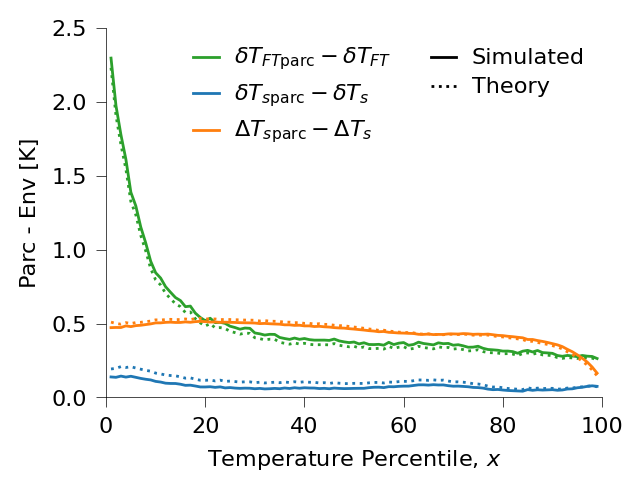

In [101]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, width['one_col'])

ax.plot(ds_quant.quant, np.average(temp_ft_parcel.diff(dim='tau_lw').squeeze() -
                                   ds_quant.T_ft_env.diff(dim='tau_lw').squeeze(), weights=lat_weights, axis=1),
        color='C2', label='$\delta T_{FT\\text{parc}} - \delta T_{FT}$')
ax.plot(ds_quant.quant, np.average(temp_ft_parcel_change_theory, weights=lat_weights, axis=0), color='C2',
        linestyle=':')



ax.plot(ds_quant.quant, np.average(temp_surf_parcel.diff(dim='tau_lw').squeeze() -
                                   ds_quant.TREFHT.diff(dim='tau_lw').squeeze(), weights=lat_weights, axis=1),
        color='C0', label='$\delta T_{s\\text{parc}} - \delta T_s$')
ax.plot(ds_quant.quant, np.average(temp_surf_parcel_change_theory, weights=lat_weights, axis=0), color='C0',
        linestyle=':')

ax.plot(ds_quant.quant, np.average((temp_surf_parcel - ds_ref.TREFHT).isel(tau_lw=0) -
                                   (ds_quant.TREFHT - ds_ref.TREFHT).isel(tau_lw=0), weights=lat_weights, axis=1),
        color='C1', label='$\Delta T_{s\\text{parc}} - \Delta T_s$')
ax.plot(ds_quant.quant, np.average(temp_surf_parcel_anom_theory, weights=lat_weights, axis=0), color='C1',
        linestyle=':')

ax.plot(-10, -10, color='k', label='Simulated')
ax.plot(-10, -10, color='k', linestyle=':', label='Theory')

update_linewidth(fig)
ax.set_ylabel('Parc - Env [K]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylim(0, 2.5)
ax.legend(ncol=2, handlelength=1.3)
update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

### Single Sample - Decomposition of $\epsilon$ contributions
Given the above theory for $\epsilon$, we now decompose the contribution due to each physical variable: $T_s, T_{FT}, r_s, p_s, \eta_D, \eta_M$.

By definition, $\epsilon=0$ if $\eta_D = \eta_M = 0$. So we only consider the actual values of $\eta_D$ and $\eta_M$, then consider the non linear contributions from variation of other parameters too.

In [75]:
def get_epsilon_cont_analytic(temp_surf=ds_use.TREFHT, temp_ft=ds_use.T_ft_env, rh_surf=ds_use.rh_REFHT,
                              p_surf=ds_use.PREFHT,
                              lapse_diff_D=ds_use.lapse_diff_D, lapse_diff_M=ds_use.lapse_diff_M,
                              temp_surf_ref=ds_ref.TREFHT, temp_ft_ref=ds_ref.T_ft_env, rh_surf_ref=ds_ref.rh_REFHT,
                              p_surf_ref=ds_ref.PREFHT, lapse_diff_D_ref=0, lapse_diff_M_ref=0, p_ft=p_ft,
                              temp_lcl_ref=temp_lcl_bolton_use, do_taylor_expansion=do_taylor_expansion):
    if not do_taylor_expansion:
        raise ValueError('This analytic assumes the extra taylor series')
    # Compute all params with reference quantities
    R_mod, _, _, beta_ft1, _, _, _ = get_theory_prefactor_terms(temp_ft_ref, p_surf_ref, p_ft)
    beta_s1 = get_theory_prefactor_terms(temp_surf_ref, p_surf_ref, p_ft,
                                         sphum=rh_surf_ref * sphum_sat(temp_surf_ref, p_surf_ref))[3]
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf_ref, temp_lcl_ref)
    sigma_exponent = np.log(sigma_lcl) / np.log(rh_surf_ref)
    sigma_ft = p_ft / p_surf_ref

    cont = {}
    cont['lapse_D'] = -beta_s1 * temp_surf_ref * R / g * np.log(sigma_lcl) * (lapse_diff_D - lapse_diff_D_ref)
    cont['lapse_M'] = beta_ft1 * temp_ft_ref * R / g * np.log(sigma_lcl / sigma_ft) * (lapse_diff_M - lapse_diff_M_ref)
    cont['rh_REFHT'] = cont['lapse_D'] / np.log(sigma_lcl) * sigma_exponent * (rh_surf - rh_surf_ref) / rh_surf_ref
    cont['rh_REFHT'] += cont['lapse_M'] / np.log(sigma_lcl / sigma_ft) * sigma_exponent * (
            rh_surf - rh_surf_ref) / rh_surf_ref
    for key in cont:
        cont[key] /= 1000
    return cont

In [76]:
# Get numerical contributions
ds_eps_num = ds_use[['TREFHT']]
ds_eps_num['lapse_D'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                           ds_use['lapse_diff_D'], 0)[0]
ds_eps_num['lapse_M'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                           0, ds_use['lapse_diff_M'])[0]
ds_eps_num = ds_eps_num.drop_vars('TREFHT')

ds_eps_num['TREFHT'] = get_epsilon_theory(ds_use.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                          ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['TREFHT'] = ds_eps_num['TREFHT'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

ds_eps_num['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_use.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                            ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['T_ft_env'] = ds_eps_num['T_ft_env'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

ds_eps_num['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_use.rh_REFHT, ds_ref.PREFHT,
                                            ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['rh_REFHT'] = ds_eps_num['rh_REFHT'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

ds_eps_num['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_use.PREFHT,
                                          ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])[0]
ds_eps_num['PREFHT'] = ds_eps_num['PREFHT'] - ds_eps_num['lapse_D'] - ds_eps_num['lapse_M']

# Get analytic contributions
ds_eps_an = get_epsilon_cont_analytic()

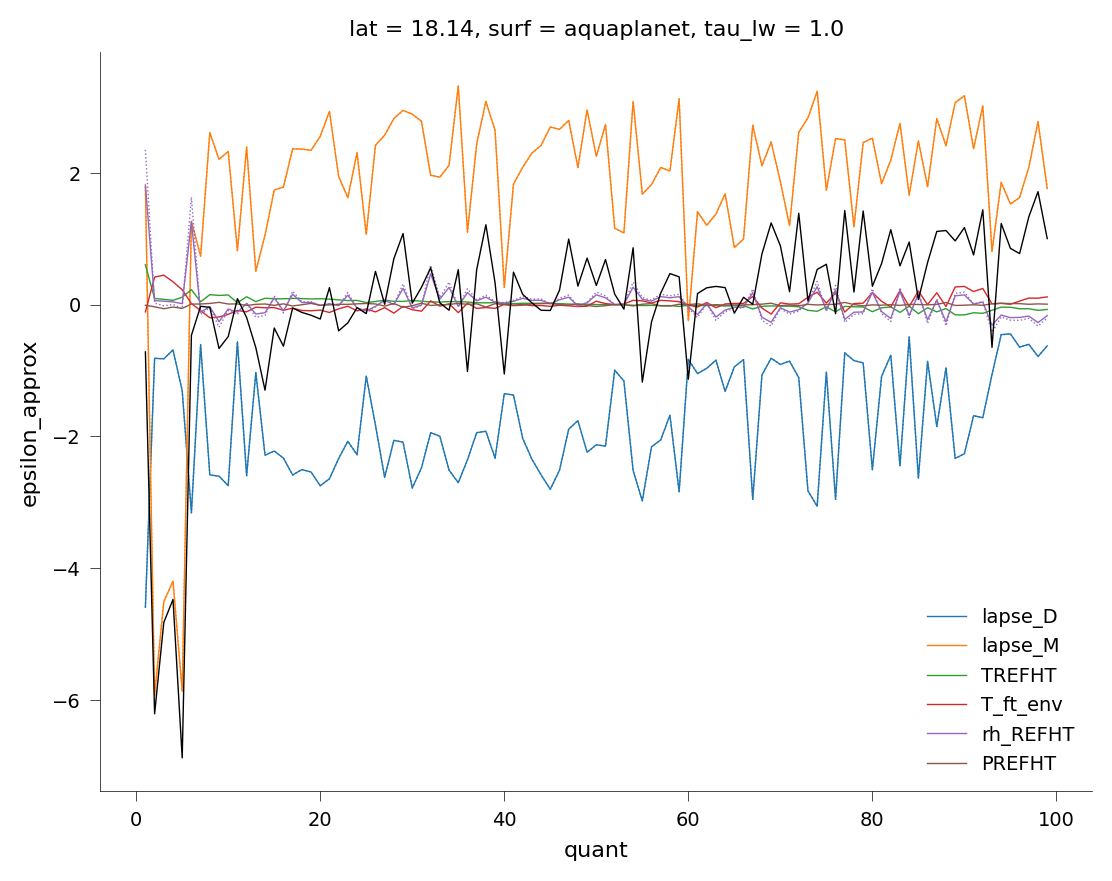

In [77]:
for j, key in enumerate(ds_eps_num):
    ds_eps_num[key].plot(color=f"C{j}", label=key)
    if key in ds_eps_an:
        ds_eps_an[key].plot(color=f"C{j}", linestyle=':')
# ds_eps['lapse_M'].plot()
ds_use['epsilon_approx'].plot(color='k')
# (ds_eps['lapse_D']+ds_eps['lapse_M']).plot(color='k', linestyle=':')
plt.gca().legend()
# ds_eps['lapse_M'].plot()

### Average over samples
For the scaling factor theory, we average over samples for a given quantile for each variable. The $\epsilon$ computed using these average variables may not equal the average of epsilon. We investigate that below.

I.e. $\overline{\epsilon} \neq \epsilon(\overline{T}_s, \overline{T}_{FT}, \overline{r}_s, ...)$

We write $A_{\epsilon \text{av}} = \overline{\epsilon} - \hat{\epsilon}(\overline{\chi})-A_z + A_{\eta_M} - A_{\eta_D}$

where the overline is an average over sample, and $\hat{\epsilon}$ is the theoretical $\epsilon$, and $\chi$ refers to all variables required to compute this.

Below we see that $A_{\epsilon \text{av}}$ has comparable magnitude to the other errors.


In [107]:
ds_av = ds_quant['aquaplanet'].mean(dim='sample')
ds_av['rh_REFHT'] = ds_av.QREFHT / sphum_sat(ds_av.TREFHT, ds_av.PREFHT)
ds_av['mse_REFHT'] = moist_static_energy(ds_av.TREFHT, ds_av.QREFHT, ds_av.ZREFHT)
ds_av['mse_ft_sat_env'] = moist_static_energy(ds_av.T_ft_env, sphum_sat(ds_av.T_ft_env, p_ft), ds_av.Z_ft_env)
ds_av['epsilon'] = ds_av['mse_REFHT'] - ds_av['mse_ft_sat_env']
ds_av['lapse_diff_D'] = ds_av.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_av['lapse_diff_M'] = ds_av.modParc1_lapse.isel(layer=1) / 1000

In [108]:
ds_av['epsilon_approx'] = get_epsilon_theory(ds_av.TREFHT, ds_av.T_ft_env, ds_av.rh_REFHT, ds_av.PREFHT,
                                             ds_av['lapse_diff_D'],
                                             ds_av['lapse_diff_M'])[0]
ds_av['lapse_M_error'], ds_av['lapse_D_error'] = get_epsilon_error(ds_av.TREFHT, ds_av.T_ft_env,
                                                                   ds_av.rh_REFHT, ds_av.PREFHT,
                                                                   ds_av.modParc1_lapse.isel(
                                                                       layer=0) / 1000 - lapse_dry,
                                                                   ds_av.modParc1_lapse.isel(layer=1) / 1000)


def get_z_error(ds):
    R_mod = get_theory_prefactor_terms(ds.T_ft_env, ds.PREFHT, p_ft)[0]
    z_diff = g * (ds.Z_ft_env - ds.ZREFHT)
    z_diff_theory = R_mod * (ds.TREFHT + ds.T_ft_env)
    z_error = (z_diff - z_diff_theory) / 1000  # units of kJ/kg
    return z_error


ds_av['z_error'] = get_z_error(ds_av)
# Averging error is the residual error after accounting for z_error, lapse_m_error and lapse_d_error
ds_av['epsilon_av_error'] = ds_av['epsilon'] - (
        ds_av['epsilon_approx'] - ds_av['z_error'] + ds_av['lapse_M_error'] - ds_av['lapse_D_error'])

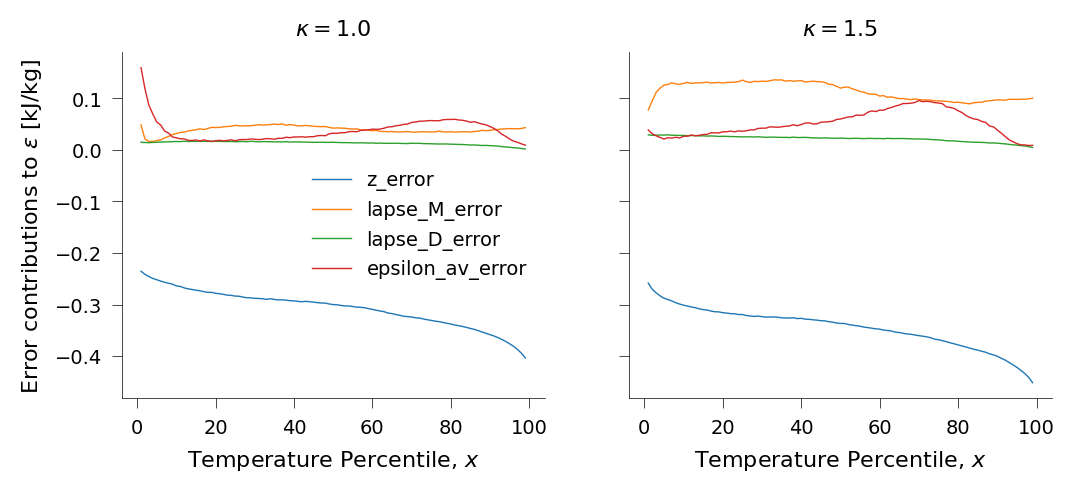

In [131]:
lat_weights = np.cos(np.deg2rad(ds_av.lat))
percentile_label = 'Temperature Percentile, $x$'

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 6)
for j in range(ds_av.tau_lw.size):
    ax[j].set_xlabel(percentile_label)
    ax[j].set_title(f"$\kappa = {ds_av.tau_lw[j]:.1f}$")
    for i, key in enumerate(['z_error', 'lapse_M_error', 'lapse_D_error', 'epsilon_av_error']):
        ax[j].plot(ds_av.quant, np.average(ds_av[key].isel(tau_lw=j), weights=lat_weights, axis=1), color=f"C{i}",
                   label=key)
ax[0].legend()
ax[0].set_ylabel('Error contributions to $\epsilon$ [kJ/kg]')
plt.show()

In [132]:
ds_av_ref = ds_av[['TREFHT', 'rh_REFHT', 'PREFHT']].median(dim='quant')
# Ensure ref values of rh and P have same value for all tau_lw. Set to coldest simulation
# ds_av_ref['rh_REFHT'] = ds_av_ref['rh_REFHT'] * 0 + ds_av_ref['rh_REFHT'].isel(tau_lw=0)
# ds_av_ref['PREFHT'] = ds_av_ref['PREFHT'] * 0 + ds_av_ref['PREFHT'].isel(tau_lw=0)
# Compute T_ft assuming perfectly SQE - two functions both give same answer
ds_av_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                       p_ft, 0, 0, ds_av_ref['TREFHT'],
                                       input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                       kwargs={'temp_surf_lcl_calc': temp_lcl_bolton_use})
# For lapse rate params, ref value cannot be zero, but make it the value in the colder simulation
ds_av_ref['lapse_diff_D'] = ds_av['lapse_diff_D']
ds_av_ref['lapse_diff_M'] = ds_av['lapse_diff_M']

In [134]:
# Get numerical contributions
ds_av_eps = ds_av[['TREFHT']]
ds_av_eps['lapse_D'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                          ds_av['lapse_diff_D'], 0)[0]
ds_av_eps['lapse_M'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                          0, ds_av['lapse_diff_M'])[0]
ds_av_eps = ds_av_eps.drop_vars('TREFHT')

ds_av_eps['TREFHT'] = get_epsilon_theory(ds_av.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                         ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['TREFHT'] = ds_av_eps['TREFHT'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

ds_av_eps['T_ft_env'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av.T_ft_env, ds_av_ref.rh_REFHT, ds_av_ref.PREFHT,
                                           ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['T_ft_env'] = ds_av_eps['T_ft_env'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

ds_av_eps['rh_REFHT'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av.rh_REFHT, ds_av_ref.PREFHT,
                                           ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['rh_REFHT'] = ds_av_eps['rh_REFHT'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

ds_av_eps['PREFHT'] = get_epsilon_theory(ds_av_ref.TREFHT, ds_av_ref.T_ft_env, ds_av_ref.rh_REFHT, ds_av.PREFHT,
                                         ds_av['lapse_diff_D'], ds_av['lapse_diff_M'])[0]
ds_av_eps['PREFHT'] = ds_av_eps['PREFHT'] - ds_av_eps['lapse_D'] - ds_av_eps['lapse_M']

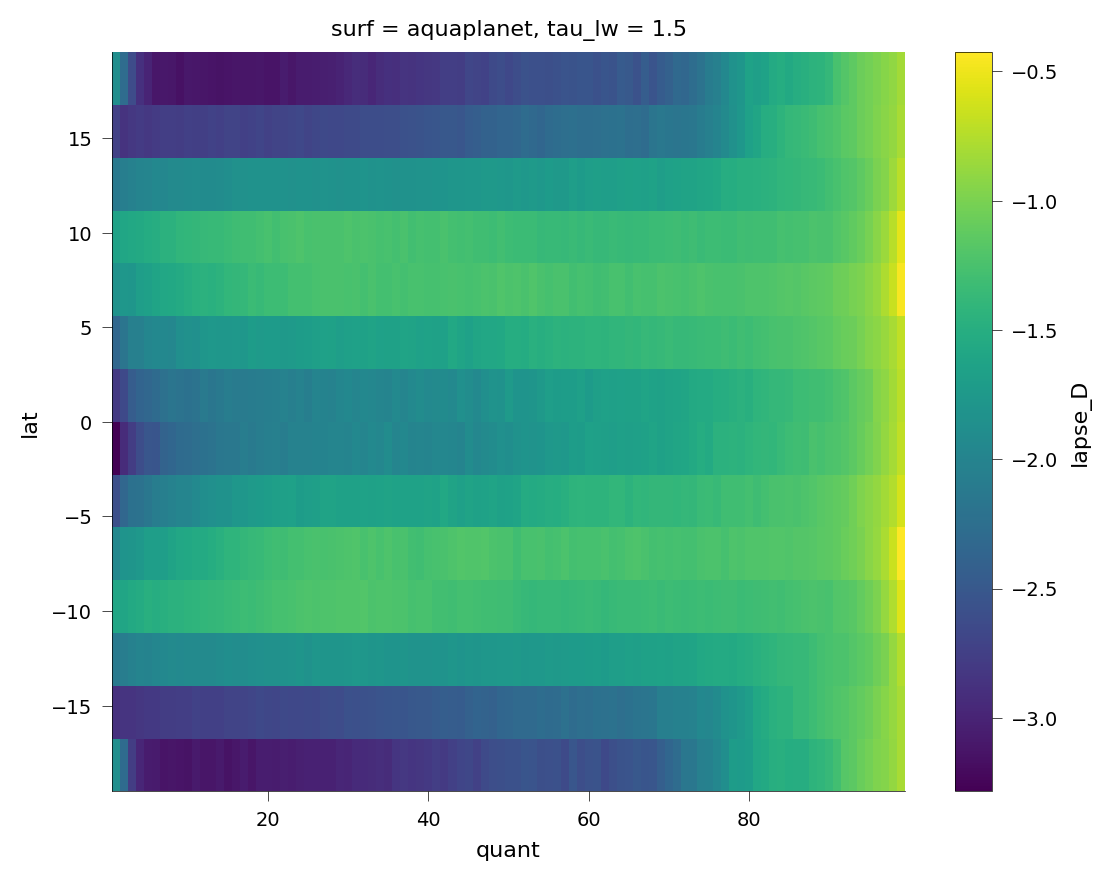

In [149]:
ds_av_eps['lapse_D'].isel(tau_lw=1).plot()

In [178]:
ds_eps = ds_use[['TREFHT']]
ds_eps['lapse_D'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       ds_use['lapse_diff_D'], 0)[0]
ds_eps['lapse_M'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       0, ds_use['lapse_diff_M'])[0]
ds_eps = ds_eps.drop_vars('TREFHT')

# ds_eps['TREFHT'] = get_epsilon_theory(ds_use.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
#                                       ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['TREFHT'] = ds_eps['TREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_use.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
#                                         ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['T_ft_env'] = ds_eps['T_ft_env'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_use.rh_REFHT, ds_ref.PREFHT,
#                                         ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['rh_REFHT'] = ds_eps['rh_REFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_use.PREFHT,
#                                       ds_use['lapse_diff_D'], ds_use['lapse_diff_M'])
# ds_eps['PREFHT'] = ds_eps['PREFHT'] - ds_eps['lapse_D'] - ds_eps['lapse_M']
#
# ds_eps = ds_eps.transpose('quant', 'surf', 'tau_lw', 'lat', 'sample')


In [28]:
ds_eps2 = copy.deepcopy(ds_eps)
eps2_ref_cont = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT,
                                   ds_ref.PREFHT, ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M'])
ds_eps2['TREFHT'] = get_epsilon_theory(ds_quant.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                       ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['T_ft_env'] = get_epsilon_theory(ds_ref.TREFHT, ds_quant.T_ft_env, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                         ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['rh_REFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_quant.rh_REFHT, ds_ref.PREFHT,
                                         ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2['PREFHT'] = get_epsilon_theory(ds_ref.TREFHT, ds_ref.T_ft_env, ds_ref.rh_REFHT, ds_quant.PREFHT,
                                       ds_ref['lapse_diff_D'], ds_ref['lapse_diff_M']) - eps2_ref_cont

ds_eps2 = ds_eps2.transpose('quant', 'surf', 'tau_lw', 'lat', 'sample')

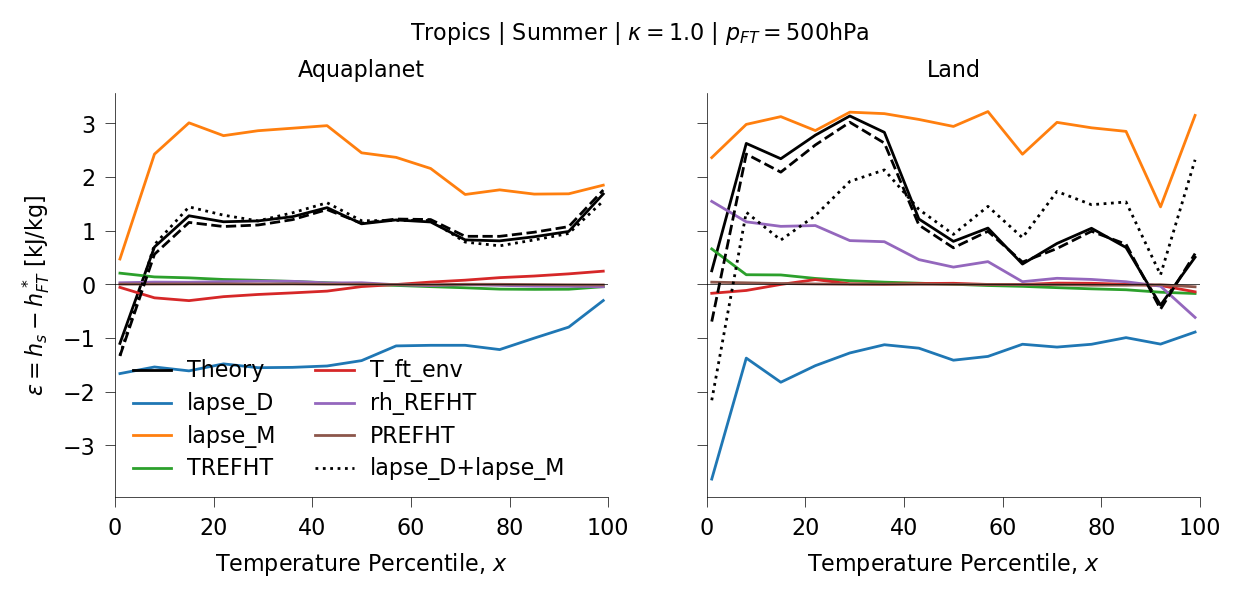

In [29]:
tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    ax[k].plot(ds_quant.quant,
               np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                          weights=lat_weights),
               color='k', label='Theory')
    for j, key in enumerate(ds_eps):
        ax[k].plot(ds_quant.quant,
                   np.average(ds_eps[key].isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                              weights=lat_weights),
                   color=f'C{j}', label=key)
    ax[k].plot(ds_quant.quant, np.average(
        (ds_eps['lapse_D'] + ds_eps['lapse_M']).isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'),
        axis=1, weights=lat_weights), color=f'k', linestyle=':', label='lapse_D+lapse_M')
    ax[k].plot(ds_quant.quant,
               np.average((ds_eps['lapse_D'] + ds_eps['lapse_M'] + ds_eps['rh_REFHT'] + ds_eps['T_ft_env']
                           ).isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'),
                          axis=1, weights=lat_weights), color=f'k', linestyle='--')
# ax[k].fill_between(ds_quant.quant, np.average(epsilon_theory.isel(surf=k).quantile(0.25, dim='sample'), axis=1,
#                                               weights=lat_weights),
#                    np.average(epsilon_theory.isel(surf=k).quantile(0.75, dim='sample'), axis=1,
#                               weights=lat_weights), alpha=0.1, color='k', edgecolor="none")
update_linewidth(fig)
ax[0].legend(ncol=2)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

In [165]:
lat_weights = np.cos(np.deg2rad(ds.lat))
percentile_label = 'Temperature Percentile, $x$'

tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    ax[k].plot(ds_quant.quant,
               np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.5, dim='sample'), axis=1,
                          weights=lat_weights),
               color='k')
    ax[k].fill_between(ds_quant.quant,
                       np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.25, dim='sample'), axis=1,
                                  weights=lat_weights),
                       np.average(epsilon_theory.isel(surf=k, tau_lw=tau_lw_ind).quantile(0.75, dim='sample'), axis=1,
                                  weights=lat_weights), alpha=0.1, color='k', edgecolor="none")

update_linewidth(fig)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

NameError: name 'ds' is not defined

### Change between simulations
Here, I look at how the above contributions change with warming.

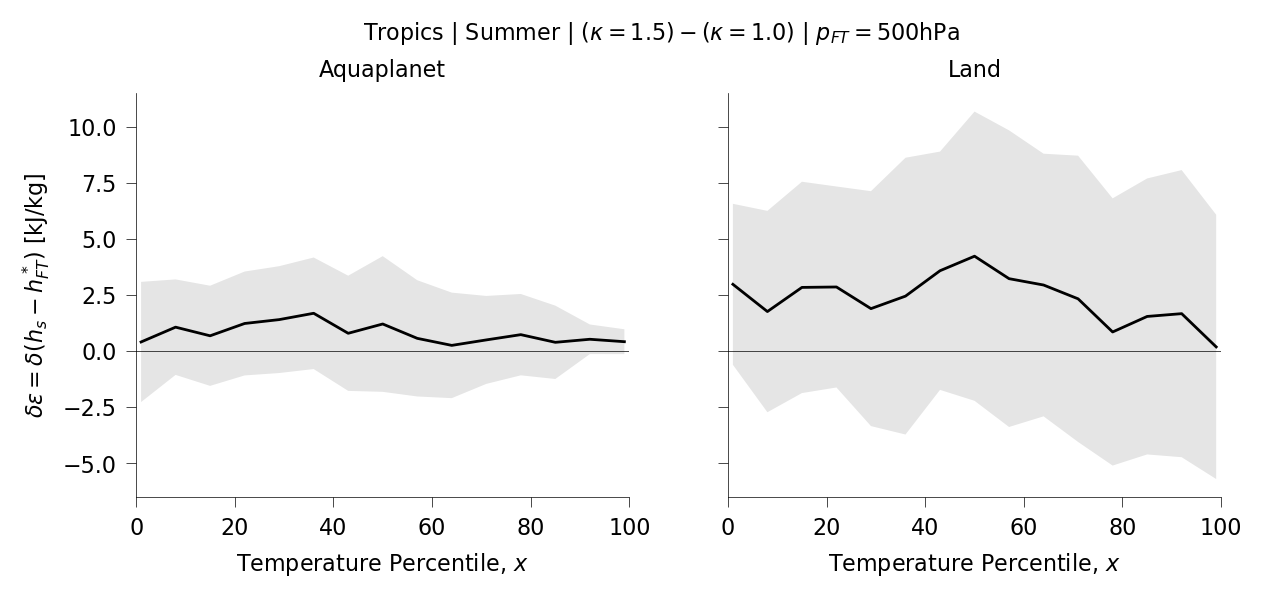

In [30]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    var = epsilon_theory.isel(surf=k).quantile(0.5, dim='sample')
    ax[k].plot(ds_quant.quant,
               np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0), axis=1, weights=lat_weights),
               color='k')
    error = np.sqrt(epsilon_theory.isel(surf=k, tau_lw=0).std(dim='sample') ** 2 +
                    epsilon_theory.isel(surf=k, tau_lw=1).std(dim='sample') ** 2)
    ax[k].fill_between(ds_quant.quant, np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0) - error, axis=1,
                                                  weights=lat_weights),
                       np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0) + error, axis=1,
                                  weights=lat_weights), alpha=0.1, color='k', edgecolor="none")

update_linewidth(fig)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_quant.tau_lw.values[1]}) - (\kappa = {ds_quant.tau_lw.values[0]})$ | "
    f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\delta \epsilon = \delta (h_s - h_{FT}^*)$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()

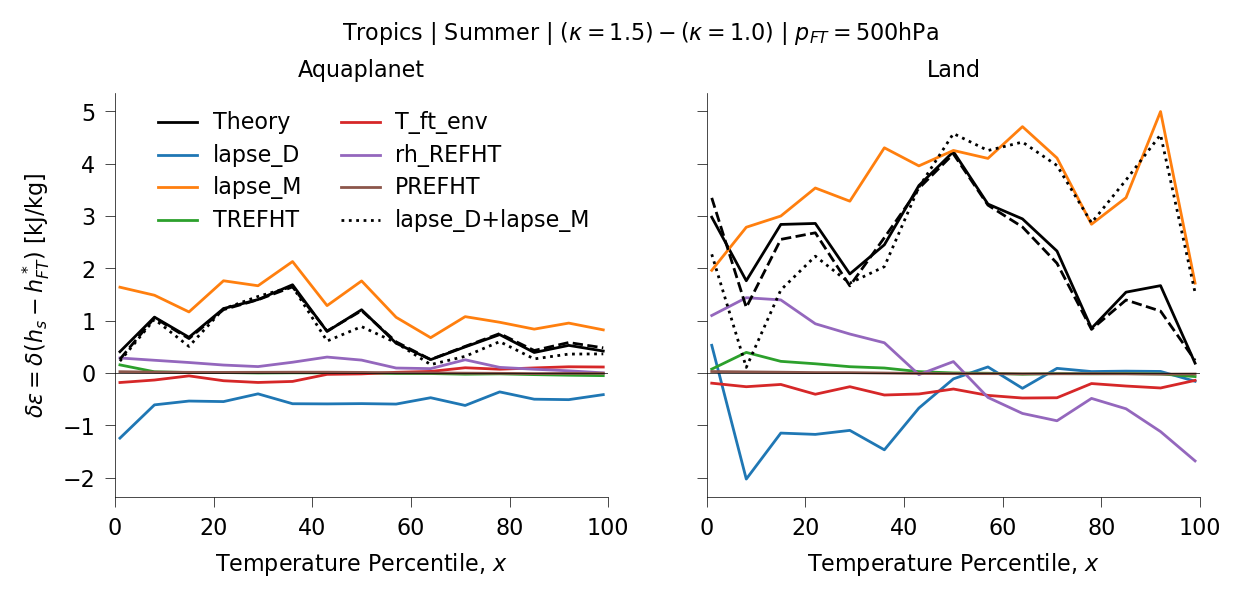

In [31]:
ds_use = ds_eps
# ds_use = ds_eps2        # For non-linear cont, takes colder sim value of lapse diff params
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    var = epsilon_theory.isel(surf=k).quantile(0.5, dim='sample')
    ax[k].plot(ds_quant.quant,
               np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0), axis=1, weights=lat_weights),
               color='k', label='Theory')
    for j, key in enumerate(ds_eps):
        ax[k].plot(ds_quant.quant,
                   np.average(ds_use[key].isel(surf=k, tau_lw=1).quantile(0.5, dim='sample') -
                              ds_use[key].isel(surf=k, tau_lw=0).quantile(0.5, dim='sample'), axis=1,
                              weights=lat_weights),
                   color=f'C{j}', label=key)
    var = (ds_use['lapse_D'] + ds_use['lapse_M']).quantile(0.5, dim='sample').isel(surf=k)
    ax[k].plot(ds_quant.quant, np.average(
        var.isel(tau_lw=1) - var.isel(tau_lw=0),
        axis=1, weights=lat_weights), color=f'k', linestyle=':', label='lapse_D+lapse_M')
    var = (ds_use['lapse_D'] + ds_use['lapse_M'] + ds_use['rh_REFHT'] + ds_use['T_ft_env']).quantile(0.5,
                                                                                                     dim='sample').isel(
        surf=k)
    ax[k].plot(ds_quant.quant, np.average(var.isel(tau_lw=1) - var.isel(tau_lw=0),
                                          axis=1, weights=lat_weights), color=f'k', linestyle='--')

update_linewidth(fig)
ax[0].legend(ncol=2)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_quant.tau_lw.values[1]}) - (\kappa = {ds_quant.tau_lw.values[0]})$ | "
    f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('$\delta \epsilon = \delta (h_s - h_{FT}^*)$ [kJ/kg]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
for k in range(ds.surf.size):
    ax[k].axhline(0, color='k', lw=ax_linewidth)
plt.show()